In [1]:
%load_ext autoreload
%autoreload 2
from exojax.spec import make_numatrix0,xsvector
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import rtcheck, moldb
import numpy as np
import tqdm
import jax.numpy as jnp
from jax import vmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
import numpy as np
from scipy.io import FortranFile
#petit
petitdir="/home/kawahara/petitRADTRANS/petitRADTRANS/input_data/opacities/lines/line_by_line/CO_all_iso/"
#f = FortranFile(petitdir+"sigma_05_900.K_0.100000bar.dat","r")
with open(petitdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)

with open(petitdir+"sigma_05_900.K_0.100000bar.dat", 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)

In [3]:
contentw

array([2.99999967e-05, 3.00000267e-05, 3.00000567e-05, ...,
       2.79999881e-03, 2.80000161e-03, 2.80000161e-03])

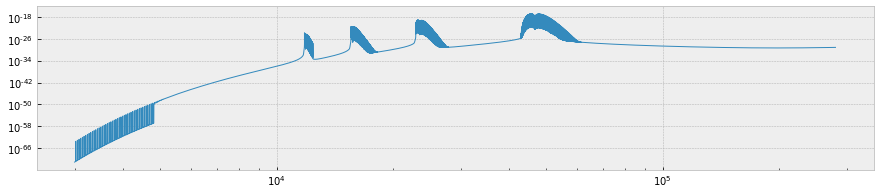

In [4]:
llow=2300.4
lhigh=2300.7
tip=20.0
species_mass=28.01
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm
fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8,xs,lw=1)
plt.yscale("log")
plt.xscale("log")
#plt.ylim(10**-31,10**-17)
#plt.xlim(llow*10.0-tip,lhigh*10.0+tip)

In [5]:
import numpy as np
import astropy.units as u
nus = 1.0/wav

In [6]:
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

In [7]:
#USE TIPS partition function
Q296=np.array([107.25937215917970,224.38496958496091,112.61710362499998,\
     660.22969049609367,236.14433662109374,1382.8672147421873])
Q1000=np.array([382.19096582031250,802.30952197265628,402.80326733398437,\
2357.1041210937501,847.84866308593757,4928.7215078125000])
qr=Q296/Q1000

In [8]:
#qr_=mdbCO.Qr([1000.0])

In [21]:
mdbCO_hit=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
mdbCO_hit.Qr([1000.0])/mdbCO_hit.Qr([900.0])

array([[0.88737276, 0.88670448, 0.88664746, 0.88699503, 0.88592656,
        0.88629919]])

In [24]:
qr=mdbCO_hit.Qr([900.0])[0]
#plt.plot((qr_/qr - 1.0)[0],".")

In [27]:
qt=np.ones_like(mdbCO.isoid,dtype=np.float64)
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    qt[mask]=qr[idx]

In [28]:
Mmol=28.010446441149536
Tref=296.0
Tfix=900.0
Pfix=0.1 #bar

Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix,Pfix, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
#+ gamma_natural(A) #uncomment if you inclide a natural width
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

In [29]:
#check memory size. If the size is large, decrease d.
d=100
ll=mdbCO.nu_lines#+mdbCO.delta_air*Pfix
numatrix=make_numatrix0(nus[0:d],ll)
print("memory size=",numatrix.nbytes/1024/1024,"MB")

memory size= 283.74481201171875 MB


In [30]:
crt=rtcheck.CheckRT() #checker
Ni=int(len(nus)/d)
xsv=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(nus[s:e],ll)
    #numatrix=make_numatrix0(nus[s:e],nu_lines)
    #crt.check_hjert(numatrix,sigmaD,gammaL) #checking x, a
    xsv = np.concatenate([xsv,xsvector(numatrix,sigmaD,gammaL,Sij)])

100%|██████████| 45362/45362 [1:06:31<00:00, 10.99it/s]


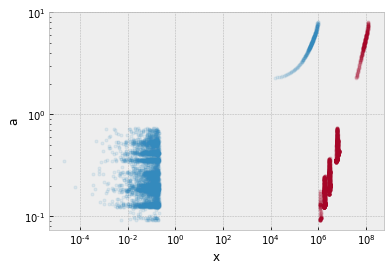

In [142]:
#checking x and a range in H(x,a)
crt.plotxa()

In [143]:
#or just use xsection
xsv=xsection(nus,ll,sigmaD,gammaL,Sij,memory_size=30)

100%|██████████| 2460/2460 [00:26<00:00, 68.31it/s]


In [56]:
#np.savez("xsv_co.npz",[wav,xsv])

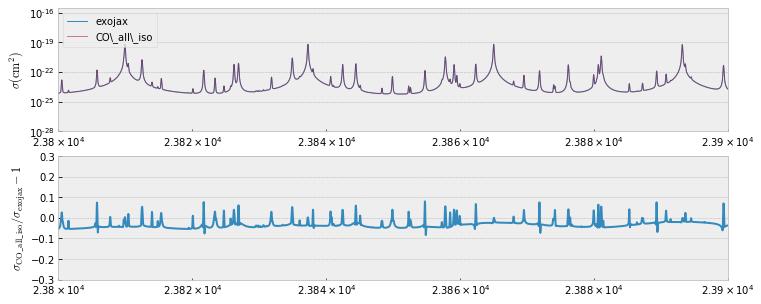

In [54]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wav*1.e8,xsv,lw=1,label="exojax")
plt.plot(wav*1.e8,xs,lw=1,alpha=0.5,label="CO\_all\_iso")
plt.yscale("log")
plt.ylabel("$\sigma (\mathrm{cm^{2}})$")
plt.xscale("log")
#plt.xlim(10000,100000)
plt.xlim(2.38*1.e4,2.39*1.e4)
plt.ylim(1.e-28,3.e-16)
plt.legend(loc="upper left")
ax=fig.add_subplot(212)
plt.plot(wav*1.e8,(xs/xsv-1))
#plt.yscale("log")
#plt.xlim(10000,100000)
plt.xlim(2.38*1.e4,2.39*1.e4)
plt.ylim(-0.3,0.3)
plt.xscale("log")
plt.ylabel("$\sigma_\mathrm{CO\_all\_iso}/\sigma_\mathrm{exojax} -1$")
plt.savefig("co_hitemp_5.png")
plt.show()

(0.01, 1.0)

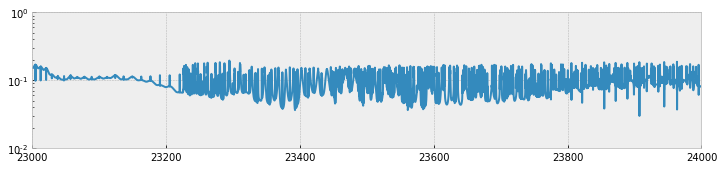

In [17]:
fig=plt.figure(figsize=(12,2.5))
plt.plot(wav*1.e8,np.abs(xsv/xs-1))
plt.yscale("log")
plt.xlim(23000,24000)
plt.ylim(1.e-2,1.e0)

In [14]:
llow=2300.4
lhigh=2300.7

In [15]:
ii=np.searchsorted(w,wH[0])
iie=ii-len(wH)
wH=np.array(wH)
absHc=absH[::-1]

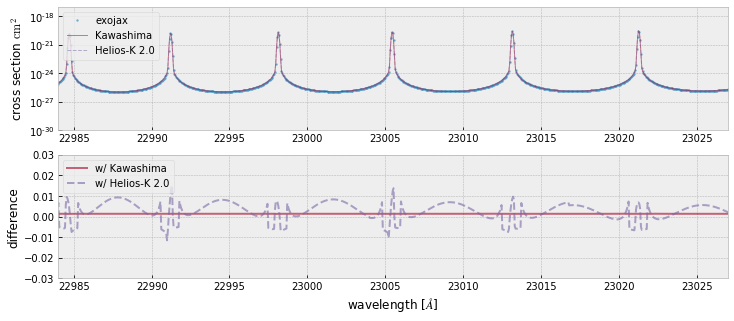

In [16]:
xsvc=xsv[::-1]

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,".",label="exojax",color="C0",markersize=3,alpha=0.5)
plt.plot(w,absco,lw=1.0,label="Kawashima",color="C1",alpha=0.5)
plt.plot(wH,absH,lw=1.0,label="Helios-K 2.0",color="C2",ls="dashed",alpha=0.5)
plt.ylim(1.e-30,1.e-17)
plt.yscale("log")
tip=20.0
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(xsvc-absco)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima")
plt.plot(w[iie:ii],(xsvc[iie+1:ii+1]-absHc)/absHc,color="C2",alpha=0.6,\
         ls="dashed",label="w/ Helios-K 2.0")
plt.ylabel("difference")
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.ylim(-0.03,0.03)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.legend(loc="upper left")
plt.savefig("comparison.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

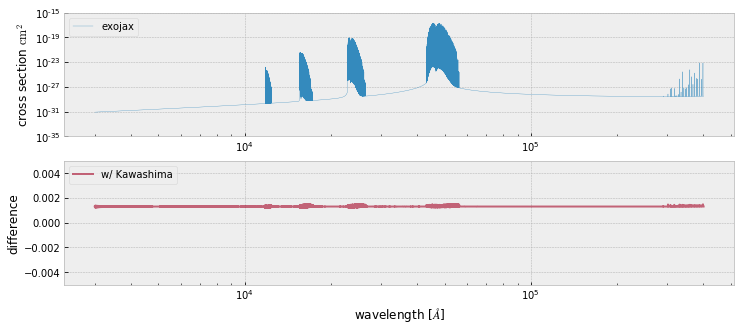

In [17]:
xsvc=xsv[::-1]
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.3,label="exojax",color="C0", rasterized=True)
#plt.plot(w,absco,lw=0.5,label="Kawashima",color="C1")
#plt.plot(wH,absH,label="Helios-K 2.0",color="C2")
plt.ylim(1.e-35,1.e-15)
#plt.xlim(50000.0,50300.0)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(xsvc-absco)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima", rasterized=True)
#plt.plot(w[iie:ii],(absHc-xsvc[iie+1:ii+1])/absHc,color="C2",alpha=0.6,\
#         ls="dashed",label="w/ Helios K-2.0")
plt.ylabel("difference")
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
#plt.xlim(50000.0,50300.0)
plt.ylim(-0.005,0.005)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("comparison_wide.pdf", bbox_inches="tight", pad_inches=0.0, dpi=400)
plt.show()

In [21]:
#Checking mass center +- 0.1 cm-1
wline=100000000/mdbCO.nu_lines
xsvc=xsv[::-1]
lw=len(w)
wid=10
xe=[]#center for exojax
xk=[]#center for kawashima
wca=[]
for wc in tqdm.tqdm(wline):
    i=np.searchsorted(w,wc)
    iq=i+wid
    ip=i-wid
    if iq<lw and ip>-1:
        xc_e=np.sum((1.e8/w[ip:iq])*xsvc[ip:iq])/np.sum(xsvc[ip:iq])
        xc_k=np.sum((1.e8/w[ip:iq])*absco[ip:iq])/np.sum(absco[ip:iq])
        xe.append((xc_e-1.e8/wc))
        xk.append((xc_k-1.e8/wc))
        wca.append(wc)
xe=np.array(xe)
xk=np.array(xk)
wca=np.array(wca)

100%|██████████| 4606/4606 [00:01<00:00, 2535.07it/s]


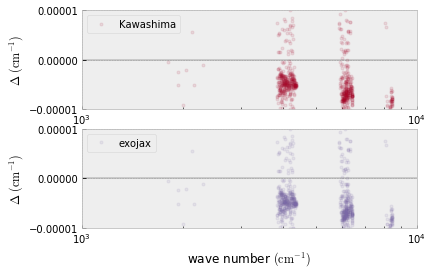

In [22]:
#+- 0.1 cm-1
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(1.e8/wca,xk,".",alpha=0.1,color="C1",label="Kawashima")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
#plt.xlim(1.e4,3.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.xscale("log")
plt.legend(loc="upper left")
ax=fig.add_subplot(212)
plt.plot(1.e8/wca,xe,".",alpha=0.1,color="C2",label="exojax")
#plt.plot(wca,xk,".")
plt.xscale("log")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.legend(loc="upper left")
plt.xlabel("wave number $(\mathrm{cm}^{-1})$")
plt.savefig("center.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

Don't worry. This trend is just due to pressure shift